## Test of the processing pipeline that will take place for every metric
> This file's purpose is to **test** the new approach we will be using to complete the project.

## Generative question:
- How does investment criteria affect the returns of a portfolio?

### Hypothesis:
- Some metrics or percentiles of them will yield portfolios with higher returns than the SP500 consistently over time.

### Steps:
1. [Load data for a single metric](#step-1)
2. [Limit span of data from 2000Q1 to 2023Q2](#step-2)
3. [Clean data if needed (outliers, missing values, etc. Maybe calculate No. of missing values, etc.)](#step-3)
4. [Plot distribution of data. We need to make sure data was fetched correctly](#step-4)
5. [Save cleaned data (.pickle)](#step-5)
6. [Select study and investment periods](#step-6)
7. [Calculate average of metric per company](#step-7)
8. [Calculate central tendency and dispersion measures for the averages](#step-8)
9. [Create portfolios of companies based percentiles on the average (or median) of metric](#step-9)
10. [Calculate returns of portfolios and SP500](#step-10)
11. [Compute the difference in returns between portfolios and SP500](#step-11)
12. [Test for statistical significance of the difference in returns](#step-12)
13. [Evaluate risk of portfolios (Maybe classify them based on sortino and sharpe ratios)](#step-13)
14. [Evaluate the sensitivity of methodology to changes in the study and investment periods](#step-14)

In [104]:
import random

import pandas as pd
import numpy as np

from scipy.ndimage import uniform_filter1d
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

from tabulate import tabulate

# Add cwd/.. to path so the imports to my user defined packages work
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))
from src.data_fetchers.metrics_fetcher import MetricsFetcher
from src.data_fetchers.classification_fetcher import ClassificationFetcher
from src.data_fetchers.returns_fetcher import ReturnsFetcher
from src.configs.file_style_configs_by_metric import file_style_configs_by_metric

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000


### Step 1
[Steps backlink](#steps)

In [105]:
data_path = os.path.join("..", "data", "companies_data")
fetcher = MetricsFetcher(data_path, file_style_configs_by_metric)

name_of_metric = "Operating Margin"
ROA_df = fetcher.fetch(name_of_metric, os.path.join("..", "data", "pickled_data"))

def change_df_index_to_period(df: pd.DataFrame):
    df.index = pd.to_datetime(df.index)
    df.index = df.index.to_period("Q")

try:
    change_df_index_to_period(ROA_df)
except TypeError: # It's already PeriodIndex, this can happen when reading cleaned data
    ...


ROA_df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 80 entries, 2000Q1 to 2019Q4
Freq: Q-DEC
Columns: 227 entries, AAPL to ZBRA
dtypes: float64(227)
memory usage: 142.5 KB


We have data from 2023Q3-2024Q4, we think these are forecasted values. They only appear for a small selection of companies.

### Step 2
[Steps backlink](#steps)

In [106]:
def select_range_of_data(df: pd.DataFrame, period_start: pd.Period, period_end: pd.Period) -> pd.DataFrame:
    return df[period_start:period_end]

ROA_df = select_range_of_data(ROA_df, pd.Period("2000Q1"), pd.Period("2019Q4"))
print(min(ROA_df.index), max(ROA_df.index))

2000Q1 2019Q4


### Step 3
[Steps backlink](#steps)

Before plotting the distribution of the data and checking for outliers, we need to make sure we are working with complete data.
So, will explore if there are missing values

In [107]:
print("Number of NaNs: ", ROA_df.isna().sum().sum())

non_float_count = (ROA_df.map(lambda x: not isinstance(x, (float, np.floating)))).sum().sum()
print("Number of non floats: ", non_float_count)

Number of NaNs:  0
Number of non floats:  0


In order to handle missing values, we will use the following approach:
- If there are less than 4 consecutive missing values, we will impute them based on the quarter from the previous year.
- If there are more than 4 consecutive missing values, we will drop the company from the dataset. Too many missing values will affect the results of the analysis.

In [108]:
def handle_nans(df: pd.DataFrame) -> pd.DataFrame:
    handle_log = ""

    df = df.copy()
    nan_mask = ROA_df.isnull()
    consecutive_nans = nan_mask.rolling(window=5).sum()
    columns_to_drop = ROA_df.columns[consecutive_nans.max() > 4]
    df = df.drop(columns=columns_to_drop)
    handle_log += f"\nDropped: {len(columns_to_drop)} compan{"ies" if len(columns_to_drop) > 1 else "y"} from dataset"

    elements_in_df = df.size
    nans_before_ffill = df.isnull().sum().sum()
    df = df.fillna(df.shift(4)) # Rows 5 and onwards get imputed with the value from the same quarter last year
    nans_before_bfill = df.isnull().sum().sum()
    df = df.fillna(df.shift(-4)) # For rows 1 - 4 we backfill based on the values from the same quarter next year

    handle_log += f"\nValues filled with past observations: {nans_before_ffill}. They represent {100*nans_before_ffill/elements_in_df:.2f} % of the data"
    handle_log += f"\nValues filled with future observations: {nans_before_bfill}. They represent {100*nans_before_bfill/elements_in_df:.2f} % of the data"

    print(handle_log)

    return df, columns_to_drop

ROA_df, dropped_companies = handle_nans(ROA_df)
print("Dropped companies", [tick for tick in dropped_companies])




Dropped: 0 company from dataset
Values filled with past observations: 0. They represent 0.00 % of the data
Values filled with future observations: 0. They represent 0.00 % of the data
Dropped companies []


### Step 4
[Steps backlink](#steps)

We will include outlier handling and distribution plotting in the same step.

There is a big problem when dealing with outliers in time series in the manner that the traditional 1.5*IQR approach does. sometimes volatility of markets or specific events lead to "shocks" in the time series data. So, instead of right out deleting them, we will filter the time series to expose the underlying patterns and obtain cleaner data. One shortcoming of this approach is that depending on the smoothing window we will be removing seasonality from the data.

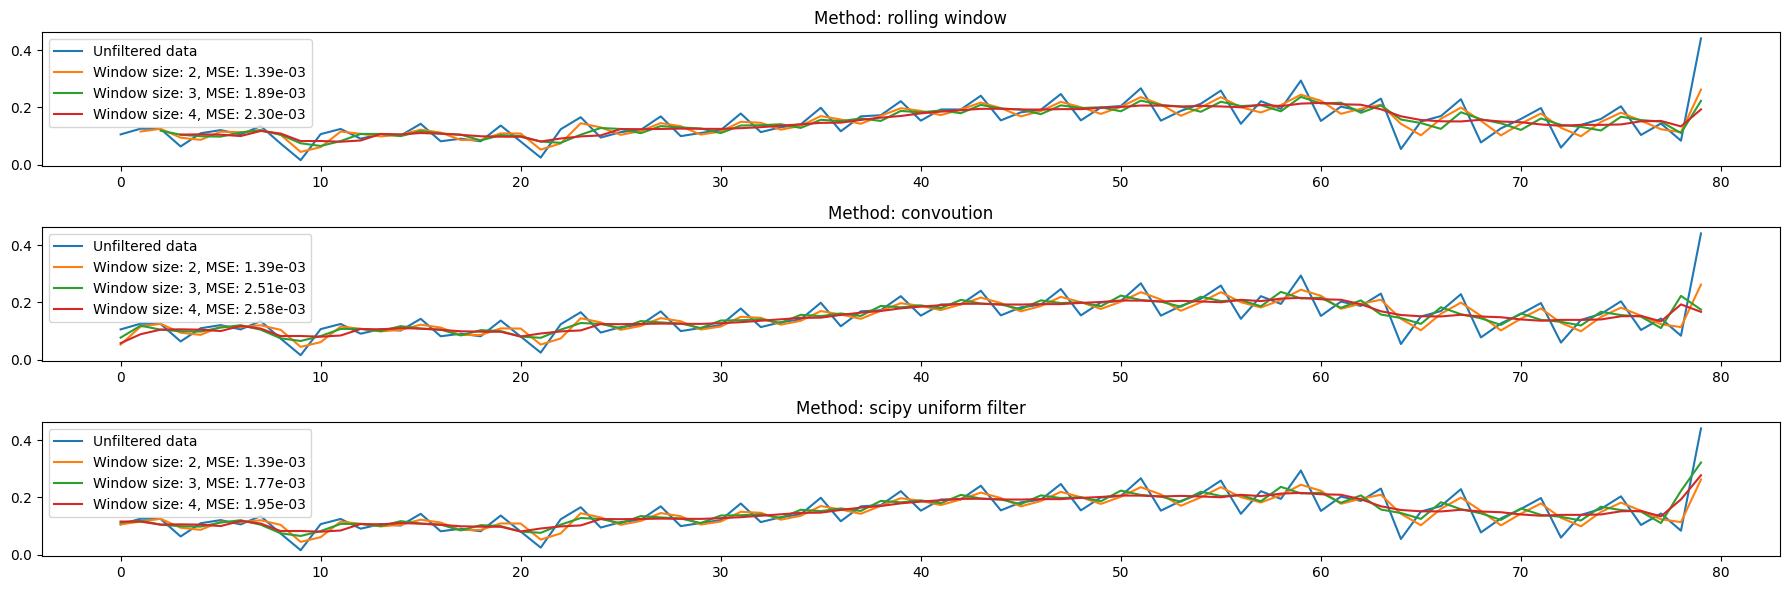

In [109]:
data = ROA_df.iloc[:, random.randint(0, len(ROA_df.columns)-1)].copy() # Let's pick one time series at random
data.index = data.index.to_timestamp()

# Let's compare the results of different alternatives
methods = {
    "rolling window": lambda i, data: data.rolling(window=i).mean().to_numpy(),
    "convoution": lambda i, data: np.convolve(data, np.ones(i) / i, mode='same'),
    "scipy uniform filter": lambda i, data: uniform_filter1d(data, size=i),
}

fig, axs = plt.subplots(3, 1, figsize=(18, 6))

for j, [method_name, method] in enumerate(methods.items()):
    axs[j].plot(data.to_numpy(), label="Unfiltered data")
    for window_size in range(2, 5):
        y = method(window_size, data)
        mse = mean_squared_error(data.to_numpy()[window_size:], y[window_size:]) # [window_size:] since some methods can return NaN for n < window_size
        axs[j].plot(y, label=f"Window size: {window_size}, MSE: {mse:.2e}")


    axs[j].set_title(f"Method: {method_name}")
    axs[j].legend()

plt.tight_layout()  # Ensure proper spacing between subplots
plt.show()

Any method to smooth/filter our data is performing equally for a window size of two. However, the scipy uniform filter ajusts to the first values faster than the other methods. So, we will use it. As seen in the plots, the oscillation that can be attributed to seasonal changes from quarter to quarter is reduced, in addition, those changes have been delayed by one quarter.
The above graph also shines a light on the fact that the data needs be normalized. Big values are hiding the underlying patterns of the data. Although this is an important consideration, we will not normalize the data for now, our portfolio creation is based on the median of the metric, so the values of the metric are not important, only their relative position.

In [110]:
window_size = 2
ROA_df_smoothed = ROA_df.copy()
for col in ROA_df.columns:
    ROA_df_smoothed[col] = uniform_filter1d(ROA_df_smoothed[col], window_size)

Let's compare the distributions of the data before and after filtering.

In [111]:

def remove_outliers(stacked_df, iqr_times: int):
    Q1 = stacked_df.quantile(0.25)
    Q3 = stacked_df.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - iqr_times * IQR
    upper_bound = Q3 + iqr_times * IQR

    non_outlier_mask = stacked_df.between(lower_bound, upper_bound)
    return stacked_df[non_outlier_mask], stacked_df[~non_outlier_mask]

stacked_df_not_smoothed = ROA_df.stack() # Stack frame for plotting ease
stacked_df_no_outliers_not_smoothed, stacked_outliers_not_smoothed = remove_outliers(stacked_df_not_smoothed, 1.5)
stacked_df_smoothed = ROA_df_smoothed.stack() # Stack frame for plotting ease
stacked_df_no_outliers_smoothed, stacked_outliers_smoothed = remove_outliers(stacked_df_smoothed, 1.5)


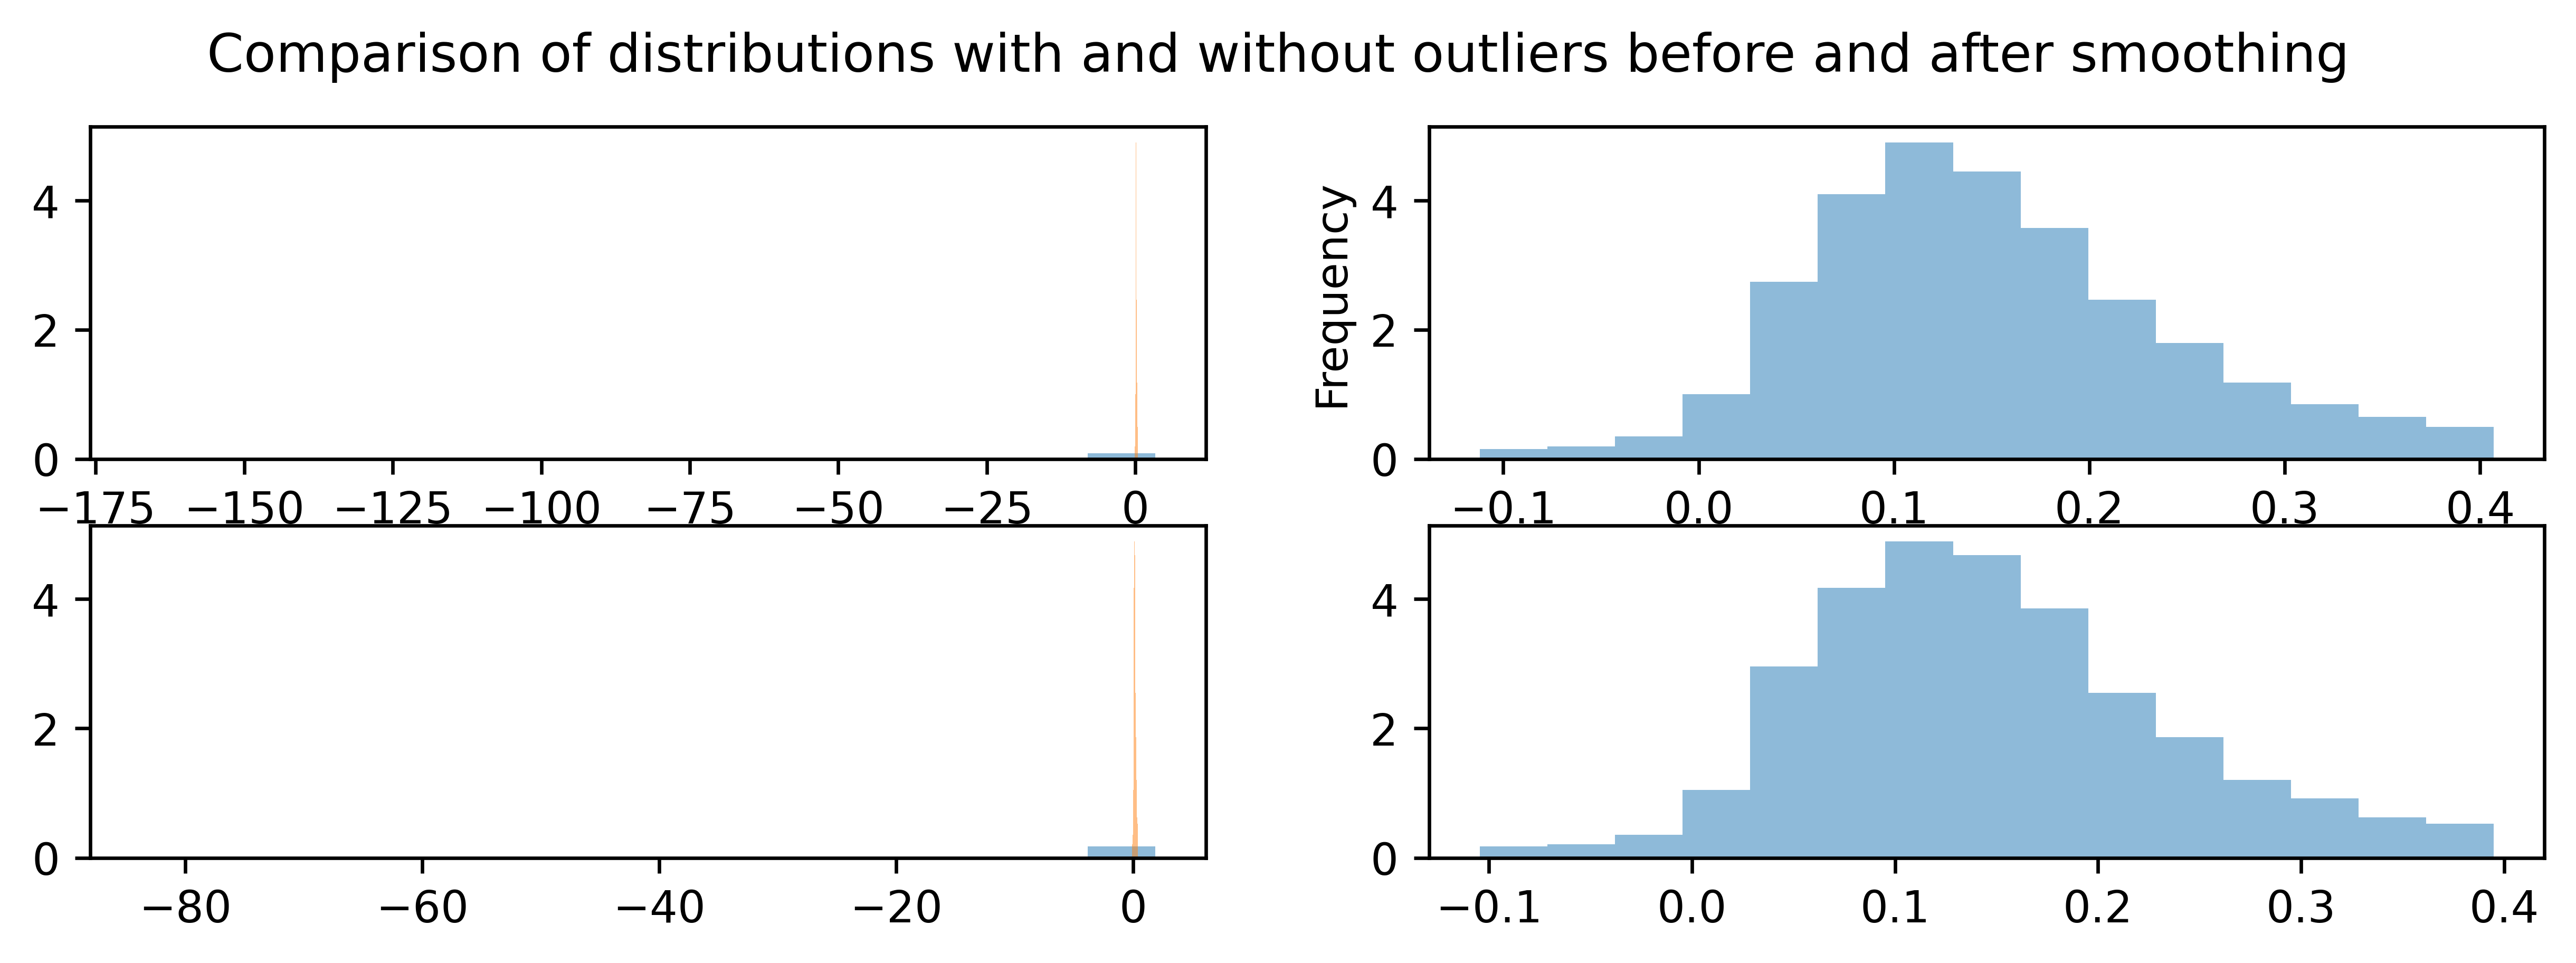

In [112]:
stacked_dfs = [[stacked_df_not_smoothed, stacked_df_no_outliers_not_smoothed],
               [stacked_df_smoothed, stacked_df_no_outliers_smoothed]]

fig, axes = plt.subplots(2, 2, figsize=(10, 3), dpi=600)
hist_options = {
    "bins": 15,
    "alpha": 0.5,
    "density": True, # Nomalize (AUC=1) so shapes are comparable
}

for i in range(len(stacked_dfs)):
    for j in range(len(stacked_dfs[i])):
        stacked_df = stacked_dfs[i][j]
        axes[i, j].hist(stacked_df, **hist_options)
        if j == 0:
            axes[i, j].hist(stacked_dfs[i][j+1], **hist_options)

        axes[0, 1].set_xlabel(f"{name_of_metric}")
        axes[0, 1].set_ylabel("Frequency")

fig.suptitle("Comparison of distributions with and without outliers before and after smoothing")
plt.show()


Smoothing did not affect the distribution of the data all that much, it just made some out of the outliers less extreme and reduced the variance of the data?

In [113]:
headers = [
    "Statistic", "Before smoothing", "After smoothing"
]
data = [
    ["Variance", stacked_df_not_smoothed.var(), stacked_df_smoothed.var()],
    ["Mean", stacked_df_not_smoothed.mean(), stacked_df_smoothed.mean()],
    ["Median", stacked_df_not_smoothed.median(), stacked_df_smoothed.median()]
]
table = tabulate(data, headers=headers, tablefmt='orgtbl')

print(table)

| Statistic   |   Before smoothing |   After smoothing |
|-------------+--------------------+-------------------|
| Variance    |           1.63986  |          0.851261 |
| Mean        |           0.126512 |          0.126552 |
| Median      |           0.14     |          0.1385   |


Yes, it reduced the median of the data. Now, comparing the before and after smoothing, one might conclude that such operation was not needed. As we are working with median and as mentioned before what matters to us is the relative position of the data. So, we will keep working with the unsmoothed the data.

One last analysis before we move onto selecting the study and investment periods. How many values are considered outliers based on the 1.5*IQR rule?

In [114]:
print(f"Number of outliers: {len(stacked_outliers_smoothed)}. They represent {100*len(stacked_outliers_smoothed)/stacked_df_smoothed.size:.2f} % of the data.")

Number of outliers: 1415. They represent 7.79 % of the data.


### Step 5
[Steps backlink](#steps)

In [115]:
fetcher._save_metric_data(os.path.join("..", "data", "pickled_data", f"{name_of_metric}_data.pickle"), ROA_df)

### Step 6
[Steps backlink](#steps)

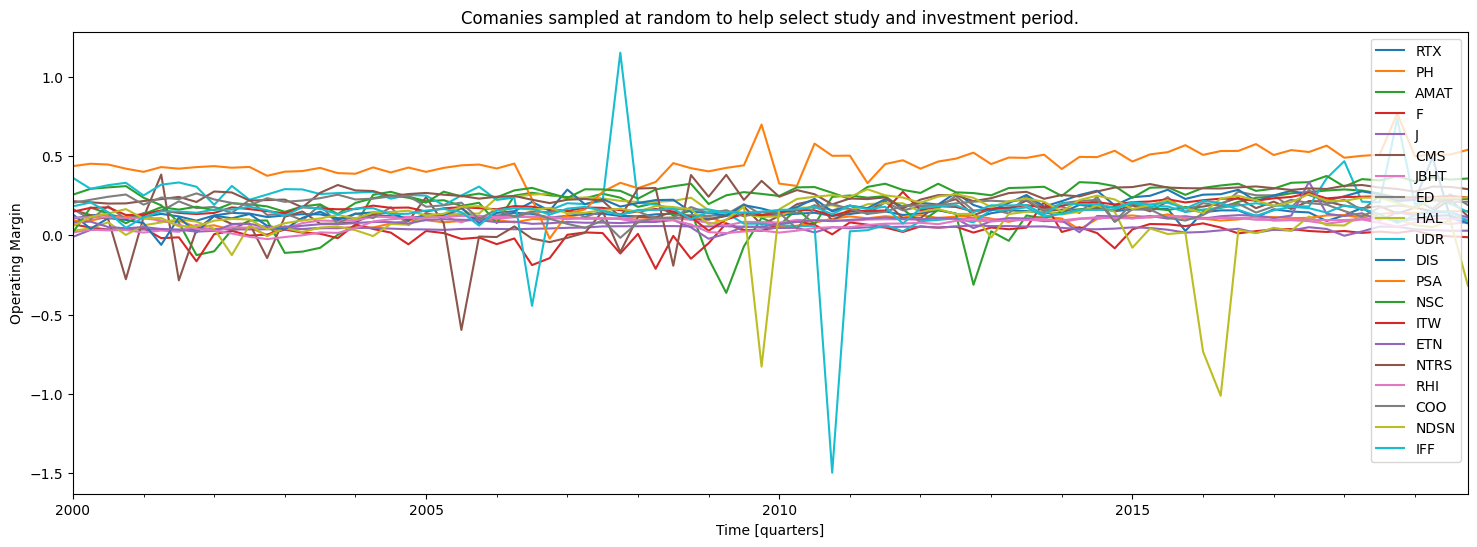

In [116]:
companies_df_position = [random.randint(0, len(ROA_df.columns)-1) for i in range(20)]
ax = ROA_df.iloc[:, companies_df_position].plot(kind="line", figsize=(18,6))
ax.set_title("Comanies sampled at random to help select study and investment period.")
ax.set_xlabel("Time [quarters]")
ax.set_ylabel(f"{name_of_metric}")

plt.show()


In [117]:
def create_study_invest_periods(start, study_quarters, investment_quarters):
    start_year, start_quarter = map(int, start.split('Q'))
    end_study_year = start_year + (start_quarter + study_quarters - 1) // 4
    end_study_quarter = (start_quarter + study_quarters - 1) % 4 + 1
    
    # Calculate the end of the study period
    end_study = f"{end_study_year}Q{end_study_quarter}"

    # Calculate the start of the investment period
    start_invest_year = end_study_year
    start_invest_quarter = end_study_quarter + 1  # Start of investment period is one quarter after the end of study
    if start_invest_quarter > 4:
        start_invest_year += 1
        start_invest_quarter -= 4

    end_invest_year = start_invest_year + (start_invest_quarter + investment_quarters - 1) // 4
    end_invest_quarter = (start_invest_quarter + investment_quarters - 1) % 4 + 1

    # Adjust the end quarter to be within 1 to 4
    if end_invest_quarter > 4:
        end_invest_quarter -= 4
        end_invest_year += 1

    start_invest = f"{start_invest_year}Q{start_invest_quarter}"
    end_invest = f"{end_invest_year}Q{end_invest_quarter}"

    return [start, end_study], [start_invest, end_invest]

study_period, invest_period = create_study_invest_periods("2000Q1", 2, 2)
print(study_period)
print(invest_period)


['2000Q1', '2000Q3']
['2000Q4', '2001Q2']


### Step 7
[Steps backlink](#steps)

In [118]:
metric_averages = ROA_df.mean(axis=0)
metric_averages.head()

AAPL    0.189250
ABT     0.165544
ADBE    0.266446
ADI     0.244825
ADP     0.195940
dtype: float64

### Step 8
[Steps backlink](#steps)

Outlier averages: 15

| Statistic   |   With outliers |   Without outliers |
|-------------+-----------------+--------------------|
| Variance    |       0.0438443 |         0.00471549 |
| Mean        |       0.126512  |         0.132136   |
| Median      |       0.1304    |         0.128625   |


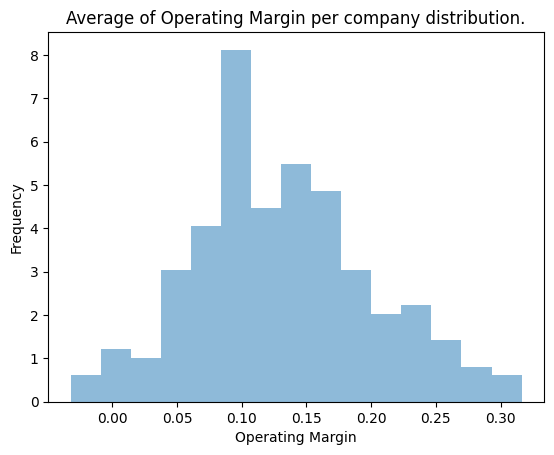

In [123]:

# Remove outliers
metric_averages_no_outliers, outliers = remove_outliers(metric_averages, 1.5)
print("Outlier averages: {}\n".format(len(outliers)))
# print(outliers)

# Print statistics
headers = [
    "Statistic", "With outliers", "Without outliers"
]
data = [
    ["Variance", metric_averages.var(), metric_averages_no_outliers.var()],
    ["Mean", metric_averages.mean(), metric_averages_no_outliers.mean()],
    ["Median", metric_averages.median(), metric_averages_no_outliers.median()]
]
table = tabulate(data, headers=headers, tablefmt='orgtbl')
print(table)

# Histogram
plt.hist(metric_averages_no_outliers, **hist_options)
plt.title(f"Average of {name_of_metric} per company distribution.")
plt.xlabel(f"{name_of_metric}")
plt.ylabel("Frequency")
plt.show()

### Step 9
[Steps backlink](#steps)

In [120]:
# Initially we create two portfolios, one for the companies above the median and another for the ones below
metric_averages_no_outliers.sort_values(inplace=True)

below_median_mask = metric_averages_no_outliers < metric_averages_no_outliers.median()
metric_averages_below = metric_averages_no_outliers[below_median_mask]
metric_averages_above = metric_averages_no_outliers[~below_median_mask]

### Step 10
[Steps backlink](#steps)

In [126]:
# Load or download returns
quarterly_returns, daily_returns = ReturnsFetcher(os.path.join("..", "data", "pickled_data", "returns_data.pickle")).fetch(metric_averages_no_outliers.index.to_list())
print(pd.DataFrame(quarterly_returns))

              ABT       MTB      AAPL      ADBE       ADI       ADM       ADP  \
quarter                                                                         
1999Q4        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2000Q1  -0.000082  0.001428  0.005572  0.009713  0.010322 -0.002156 -0.001160   
2000Q2   0.004156  0.000400 -0.003162  0.004270  0.000512 -0.000410  0.001970   
2000Q3   0.001398  0.002171 -0.007082  0.003484  0.002668 -0.001014  0.003680   
2000Q4   0.000611  0.004864 -0.007692 -0.002539 -0.005040  0.009103 -0.000673   
2001Q1  -0.000104  0.000671  0.007338 -0.005640 -0.004277 -0.001694 -0.002168   
2001Q2   0.000496  0.001334  0.001636  0.005783  0.004120  0.000146 -0.001225   
2001Q3   0.001521 -0.000123 -0.006071 -0.010609 -0.003646  0.000453 -0.000634   
2001Q4   0.001286 -0.000119  0.005903  0.004963  0.005955  0.002267  0.003656   
2002Q1  -0.000820  0.001747  0.001798  0.004870  0.000789 -0.000252  0.000018   
2002Q2  -0.004683  0.001120 

### Step 11
[Steps backlink](#steps)

### Step 12
[Steps backlink](#steps)

### Step 13
[Steps backlink](#steps)

### Step 14
[Steps backlink](#steps)